# Statistics

This page presents statistics of solar irradiance monitoring stations using data from SolarStations.org.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from datetime import datetime as dt
from IPython.display import Markdown as md
from matplotlib.lines import Line2D

In [2]:
path = 'https://solarstations.org/_downloads/f85f41dda48ab008055bbfad91e578b2/SolarStationsOrg-station-catalog.csv'
df = pd.read_csv(path)

In [3]:
dfs = df[['Station full name','Time period']]
dfs.index = dfs['Station full name']
dfs = dfs.drop(columns=['Station full name'])

# make different colors based on stations status
dfs['color'] = 'red'
dfs['color'] = dfs['color'].mask(dfs['Time period'].str.endswith('-'), 'green').mask(dfs['Time period'].str.endswith('?'), 'blue')

# Drop stations with unknown time period ('?' or '')
dfs = dfs.loc[~dfs['Time period'].isin(['?', '']), :]

# define start operation period
dfs['start'] = dfs['Time period'].str[:4].astype(int)

# Drop stations with only one year of data
dfs = dfs.loc[~(dfs['Time period'] == dfs['start'].astype(str)), :]

# define end operation period
dfs['end'] = dfs['Time period'].str[4:]
dfs['end'] = dfs['Time period'].str[5:].mask(dfs['Time period'].str.endswith('-'), dt.now().year).mask(dfs['Time period'].str.endswith('-?'), dt.now().year).mask(dfs['Time period'].str.endswith('-?'), dt.now().year)
dfs['end'] = dfs['end'].astype(int)

# sort the dataframe based on the start operation date and station status (color)
dfs = dfs.sort_values(['start','color'], ascending=False)

dfs = dfs.reset_index()

First, let's visualize the operating period of all of the known stations.

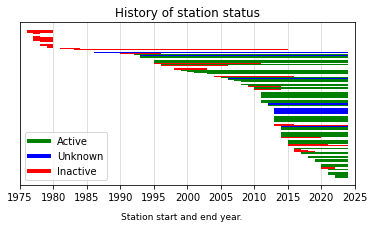

In [4]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.barh(dfs.index, dfs['end']-dfs['start'], left=dfs['start'], color=dfs['color'], zorder=2)
ax.set_yticks([])
ax.set_title('History of station status')
ax.set_xticks(np.arange(1970,dt.today().year+5,5))
ax.set_xlim(1975,dt.today().year+1)
ax.grid(alpha=0.5, zorder=-1)
plt.figtext(0.5, -0.03, 'Station start and end year.', wrap=True, horizontalalignment='center', fontsize=9)
# custom legend
custom_lines = [Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='red', lw=4)]
ax.legend(custom_lines, ['Active', 'Unknown', 'Inactive']);

Let's take a closer look at the current active stations and their measurement records.

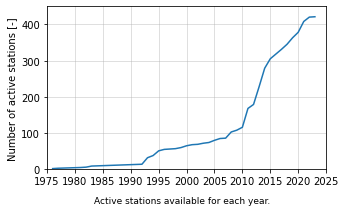

In [5]:
active_stations_count = dfs.loc[dfs['color']=='green', 'start'].value_counts().sort_index()

fig, axes = plt.subplots(figsize=(5, 3))
axes.plot(active_stations_count.cumsum())

axes.set_ylabel('Number of active stations [-]')
axes.grid(alpha=0.5)
axes.set_xticks(np.arange(1970, dt.today().year+5, 5))
axes.set_xlim(1975, dt.today().year+1)
axes.set_ylim(0, np.ceil((active_stations_count.cumsum().max()+3)/50)*50)
plt.figtext(0.5, -0.03, 'Active stations available for each year.',
            wrap=True, horizontalalignment='center', fontsize=9)
plt.show()

In [6]:
a = dfs.loc[dfs['color']=='green']
year = 1993
stations_before_year = len(a.loc[a['start']<year])
percent_before_year = round(1-(len(a)-len(a.loc[a['start']<year]))/len(a),3)*100
total_active = len(a)

last_20_years = dt.today().year - 20
stations_last_20_years = len(a.loc[a['start']>last_20_years])
percent_last_20_years = round(1-(len(a)-len(a.loc[a['start']>last_20_years]))/len(a),3)*100

df['Unknown_status'] = list(map(lambda x: str(x).endswith('?'), df['Time period']))
dfu = df.loc[df['Unknown_status']]

In [47]:
md(f'The following conclusions can be drawn from the figures above: \n'
   f'* There are currently {total_active} active stations out of the {dfs.shape[0]} known stations\n'
   f'* Of the active stations, only {stations_before_year} have been in operation before {year} (~{percent_before_year:.0f}%) \n'
   f'* The majority of the active stations ({stations_last_20_years}) have been in operation for less than 20 years (~{int(percent_last_20_years)}%) \n'
   f'* There are {len(dfu)} stations ({len(dfu)/dfs.shape[0]*100:.0f}%) whose operation status is unknown, which demonstrates a huge barrier to accessing information and data from solar stations!'
)

The following conclusions can be drawn from the figures above: 
* There are currently 421 active stations out of the 760 known stations
* Of the active stations, only 14 have been in operation before 1993 (~3%) 
* The majority of the active stations (347) have been in operation for less than 20 years (~82%) 
* There are 111 stations (15%) whose operation status is unknown, which demonstrates a huge barrier to accessing information and data from solar stations!

### Dataset duration

The figure below provides an overview of the operation duration of the active and inactive stations.

In [8]:
# use only active and inactive stations (remove unknown status)
dfs_known = dfs.loc[dfs['color'].isin(['green','red'])].copy()
# find the operation years for each station
dfs_known['operation_years'] = dfs_known['end'].subtract(dfs_known['start'])

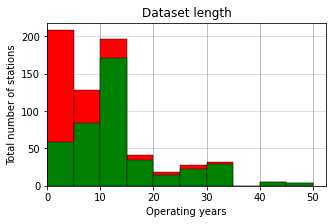

In [9]:
step_size = 5
bins = np.arange(0, dfs_known['operation_years'].max()+step_size, step_size)

fig, ax = plt.subplots(figsize=(5, 3))
dfs_known.loc[:, 'operation_years'].hist(
    ax=ax, bins=bins, zorder=2, color='red', label='Inactive',
    edgecolor='black', linewidth=0.4)

dfs_known.loc[dfs_known['color']=='green', 'operation_years'].hist(
    ax=ax, bins=bins, zorder=2, color='green', label='Active',
    edgecolor='black', linewidth=0.4)

ax.set_ylabel('Total number of stations')
ax.grid(alpha=0.5, which='both', axis='y', zorder=-1)
ax.set_xlabel('Operating years')
ax.set_title('Dataset length')
ax.set_xlim(0, None)
plt.show()

The graph shows that most of the stations with measurement record greater than 15 years remain in operation.

### Historical and active stations

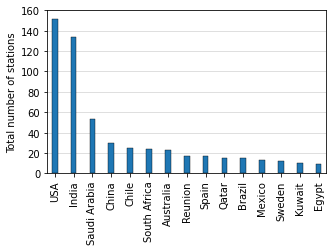

In [48]:
# Top 15 countries
countries = df.groupby('Country').count()['Station full name'].sort_values(ascending=False)[:15]
# Plot
fig, axes = plt.subplots(figsize=(5,3))
countries.plot.bar(zorder=2, width=0.3, edgecolor='black', linewidth=0.4)
axes.set_ylabel('Total number of stations')
axes.set_ylim(0, countries.iloc[0]+5)
axes.set_yticks(np.arange(0,countries.iloc[0]+20,20))
axes.grid(alpha=0.5, which='both', axis='y', zorder=-1)
axes.set_xlabel('')
plt.show()

In [49]:
print('List of historical and active networks:')
df['Network'].str.replace(' ','').str.split(';', expand=True).stack().value_counts()

List of historical and active networks:


SRRA                                                    123
ESMAP                                                    89
BSRN                                                     80
WEST                                                     52
NOAA                                                     39
IOS-net                                                  26
SAURAN                                                   22
WMORRC                                                   17
BOM                                                      15
QEERI                                                    15
SONDA                                                    14
AEMET                                                    14
FONDEF                                                   13
WMOGAW                                                   12
SMHI                                                     12
enerMENA                                                 10
SURFRAD                                 

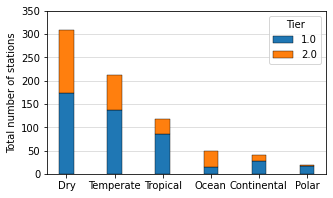

In [50]:
# Stations per KG climate zone
# Break down the station into Tier
climate_zone = df.groupby(['Koeppen Geiger climate zone','Tier']).count()['Station full name'].unstack('Tier').fillna(0)
# Find the total number of stations (Tier 1 + Tier 2)
climate_zone['sum'] = climate_zone[1.0] + climate_zone[2.0]
# Sort the dataframe from high number of stations to low
climate_zone.sort_values(by='sum', ascending=False, inplace=True)
# drop the 'sum' column for easier plotting
climate_zone.drop(columns='sum', inplace=True)

# plot
fig, axes = plt.subplots(figsize=(5,3))
climate_zone.plot.bar(ax=axes, zorder=2, width=0.3, rot=0, stacked=True,
                     edgecolor='black', linewidth=0.4)
axes.set_ylim(0, climate_zone.iloc[0][1.0]+climate_zone.iloc[0][2.0]+5)
axes.set_yticks(np.arange(0,climate_zone.iloc[0][1.0]+climate_zone.iloc[0][2.0]+50,50))
axes.grid(alpha=0.5, which='both', axis='y', zorder=-1)
axes.set_ylabel('Total number of stations')
axes.set_xlabel('')
plt.show()

## Zooming in on active stations

The remainder of the plots and statistics will be based only on the Active stations.

In [13]:
# create a column indicating if a station is active
df['Active'] = df['Time period'].str.endswith('-')
# create a new dataframe containing only the active stations

# REMOVE THE ==True WHEN THERE ARE NO NAN VALUES
dfa = df.loc[df['Active']==True]
print(f'The number of active stations: {len(dfa)}')

The number of active stations: 421


The figure below shows the number of active stations for the top 5 countries.

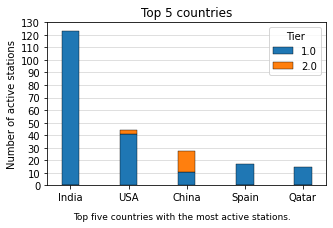

In [14]:
# Break down the station into Tier
countries_tier_active = dfa.groupby(['Country','Tier']).count()['Station full name'].unstack('Tier').fillna(0)
# Find the total number of stations (Tier 1 + Tier 2)
countries_tier_active['sum'] = countries_tier_active[1.0] + countries_tier_active[2.0]
# Sort the dataframe from high number of stations to low
countries_tier_active.sort_values(by='sum', ascending=False, inplace=True)
# drop the 'sum' column for easier plotting
countries_tier_active.drop(columns='sum', inplace=True)

# plot
fig, axes = plt.subplots(figsize=(5,3))
countries_tier_active[:5].plot.bar(ax=axes, zorder=2, width=0.3, rot=0, stacked=True,
                                  edgecolor='black', linewidth=0.4)  # plot only the top 5 countries
axes.set_yticks(np.arange(0, countries_tier_active.iloc[0][1.0]+countries_tier_active.iloc[0][2.0]+10, 10))
axes.grid(alpha=0.5, which='both', axis='y', zorder=-1)
axes.set_ylabel('Number of active stations')
axes.set_xlabel('')
axes.set_title('Top 5 countries')
plt.figtext(0.5, -0.03, 'Top five countries with the most active stations.', wrap=True, horizontalalignment='center', fontsize=9);

In [15]:
networks = dfa['Network'].str.replace(' ','').str.split(';', expand=True).stack().value_counts()

md(f"Most of the active stations belong to a network, which makes their data easier to access (partly because they usually have a website):\n"
   f'* {networks.index[0]} : {networks.iloc[0]} \n'
   f'* {networks.index[1]} : {networks.iloc[1]} \n'
   f'* {networks.index[2]} : {networks.iloc[2]} \n'
   f'* {networks.index[3]} : {networks.iloc[3]} \n'
   f'* {networks.index[4]} : {networks.iloc[4]} \n'
   f'* {networks.index[5]} : {networks.iloc[5]} \n'
   f'* {networks.index[6]} : {networks.iloc[6]} \n'
   f'* {networks.index[7]} : {networks.iloc[7]} \n'
   f'* {networks.index[8]} : {networks.iloc[8]} \n'
   f'* {networks.index[9]} : {networks.iloc[9]} \n'
   f'* {networks.index[10]} : {networks.iloc[10]} \n'
)

Most of the active stations belong to a network, which makes their data easier to access (partly because they usually have a website):
* SRRA : 123 
* ESMAP : 63 
* BSRN : 61 
* IOS-net : 15 
* QEERI : 15 
* AEMET : 14 
* enerMENA : 10 
* WMORRC : 10 
* WMOGAW : 8 
* SURFRAD : 7 
* SOLRAD : 7 


## Breakdown by continent and climate

In [52]:
continents = dfa.groupby('Continent').count().sort_values(by='Continent')['Station full name']
continents

Continent
Africa            59
Antarctica         6
Asia             209
Europe            56
North America     60
Oceania            9
South America     16
Name: Station full name, dtype: int64

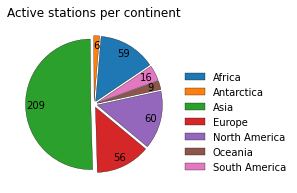

In [54]:
fig, axes = plt.subplots(figsize=(3, 3))

autopct = lambda x: '{:.0f}'.format(x * continents.sum() / 100)

pie = axes.pie(continents, autopct=autopct, pctdistance=0.85, startangle=34,
               explode=np.ones(7)*0.05,
               wedgeprops = {'linewidth': 0.3, 'edgecolor': 'black'})
axes.legend(continents.index, loc=2, bbox_to_anchor=(1,0.75), frameon=False)
axes.set_title('Active stations per continent');

In [36]:
# land areas of contients per km^2 from Wikipedia
continent_area={
    'Asia':44614000,
    'Africa':30365000,
    'North America':24230000,
    'South America':17814000,
    'Antarctica':14200000,
    'Europe':10000000,
    'Oceania':8510926
   }

In [37]:
countries_continent_tier_active = dfa.groupby(['Continent','Tier']).count()['Station full name'].unstack('Tier').fillna(0)
station_per_km = pd.DataFrame(dtype='float64')

for i in continents.index:
    station_per_km[i] = countries_continent_tier_active.loc[i]/continent_area[i]*1000000 # this is stations per Tm^2

station_per_km = station_per_km.T
# Find the total number of stations (Tier 1 + Tier 2)
station_per_km['sum'] = station_per_km[1.0] + station_per_km[2.0]
# Sort the dataframe from high number of stations to low
station_per_km.sort_values(by='sum', ascending=False, inplace=True)
# drop the 'sum' column for easier plotting
station_per_km.drop(columns='sum', inplace=True)

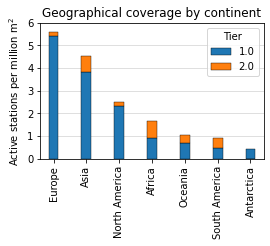

In [55]:
fig, axes = plt.subplots(figsize=(4, 2.5))
station_per_km.plot.bar(ax=axes, zorder=2, width=0.3, rot=90, stacked=True,
                        edgecolor='black', linewidth=0.4)
axes.set_yticks(np.arange(0,station_per_km.iloc[0][1.0]+station_per_km.iloc[0][2.0]+1,1))
axes.grid(alpha=0.5, which='both', axis='y', zorder=-1)
axes.set_ylabel('Active stations per million m$^2$')
axes.set_xlabel('')
axes.set_title('Geographical coverage by continent');

In [39]:
# Stations per KG climate zone
# Break down the station into Tier
climate_zone = dfa.groupby(['Koeppen Geiger climate zone','Tier']).count()['Station full name'].unstack('Tier').fillna(0)
# Find the total number of stations (Tier 1 + Tier 2)
climate_zone['sum'] = climate_zone[1.0] + climate_zone[2.0]
# Sort the dataframe from high number of stations to low
climate_zone.sort_values(by='sum', ascending=False, inplace=True)
# drop the 'sum' column for easier plotting
climate_zone.drop(columns='sum', inplace=True)

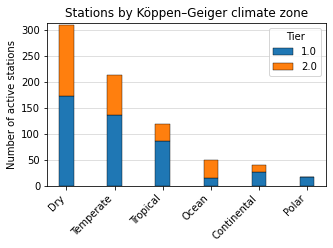

In [59]:
fig, axes = plt.subplots(figsize=(5,3))
climate_zone.plot.bar(ax=axes, zorder=2, width=0.3, rot=0, stacked=True,
                      edgecolor='black', linewidth=0.4)
axes.set_ylim(0, climate_zone.iloc[0][1.0]+climate_zone.iloc[0][2.0]+5)
axes.grid(alpha=0.5, which='both', axis='y', zorder=-1)
axes.set_ylabel('Number of active stations')
axes.set_xlabel('')
axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha='right')
axes.set_title('Stations by Köppen–Geiger climate zone')
plt.show()

## Breakdown by elevation and latitude

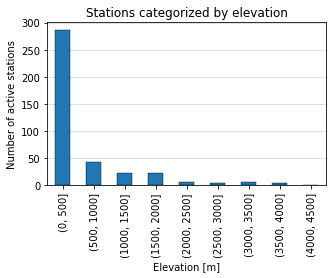

In [60]:
stations_per_500m = dfa.groupby(pd.cut(dfa['Elevation'], np.arange(0, 5000, 500)), observed=False)['Station full name'].count()

fig, axes = plt.subplots(figsize=(5, 3))
stations_per_500m.plot.bar(zorder=2, edgecolor='black', linewidth=0.4)
axes.set_yticks(np.arange(0, stations_per_500m[1]+50, 50))
axes.grid(alpha=0.5, which='both', axis='y', zorder=-1)
axes.set_ylabel('Number of active stations')
axes.set_xlabel('Elevation [m]')
axes.set_title('Stations categorized by elevation');

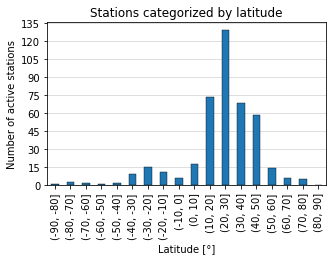

In [26]:
stations_per_10deg = dfa.groupby(pd.cut(dfa['Latitude'], np.arange(-90, 90+10, 10)), observed=False)['Station full name'].count()

fig, axes = plt.subplots(figsize=(5, 3))
stations_per_10deg.plot.bar(zorder=2, edgecolor='black', linewidth=0.4)
axes.set_yticks(np.arange(0, stations_per_10deg.max()+10, 15))
axes.grid(alpha=0.5, which='both', axis='y', zorder=-1)
axes.set_ylabel('Number of active stations')
axes.set_xlabel('Latitude [°]')
axes.set_title('Stations categorized by latitude');

## Station tier

The figure below shows the percentage of active stations categorized as either Tier 1 or Tier 2. It can be observed that most of the active stations are Tier 1, which means that they measure global horizontal irradiance (GHI), diffuse horizontal irradiance (DHI) using a shadow ball, and direct normal irradiance (DNI) using a pyrheliometer mounted on a solar tracker. For more information on the station tier classifications, see [the station requirements page](station_requirements).

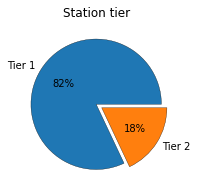

In [61]:
# Station tier
tier_rename = {1: 'Tier 1', 2: 'Tier 2'}

fig, axes = plt.subplots(figsize=(3, 3))
dfa['Tier'].map(tier_rename).convert_dtypes().value_counts().\
    plot.pie(autopct='%1.0f%%', explode=[0, 0.1],
             wedgeprops = {'linewidth': 0.3, 'edgecolor': 'black'})
axes.set_ylabel('')
axes.set_title('Station tier');

## Components

This section is not active -- requires more careful analysis.

G         367
D         358
B         353
IR         36
UV         29
PAR        14
RSI         8
GTI         2
Albedo      2
RSR         1
Name: count, dtype: int64

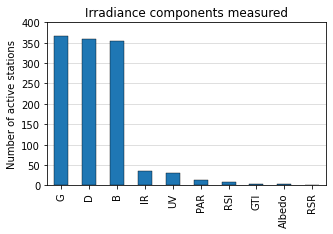

In [62]:
component_dict = {
    'G': 'GHI',
    'D': 'DHI',
    'B': 'DNI',
}

components = dfa['Components'].str.split(';', expand=True).stack().value_counts()

fig, axes = plt.subplots(figsize=(5, 3))
components.plot.bar(zorder=2, edgecolor='black', linewidth=0.4)
axes.set_yticks(np.arange(0,components.iloc[0]+50,50))
axes.grid(alpha=0.5, which='both', axis='y', zorder=-1)
axes.set_ylabel('Number of active stations')
axes.set_title('Irradiance components measured');
components

In [63]:
dfa['Components'].str.split(';', expand=True).stack().value_counts()

G         367
D         358
B         353
IR         36
UV         29
PAR        14
RSI         8
GTI         2
Albedo      2
RSR         1
Name: count, dtype: int64

## Data availability

In [29]:
df_un = dfa[(dfa['Data availability'].isna()) | (dfa['Data availability']=='Not available')]
df_av = dfa[(dfa['Data availability']=='Freely') | (dfa['Data availability']=='Free')]
df_req = dfa[dfa['Data availability']=='Upon request']

In [30]:
md(f'Finding and downloading data from solar stations can be a tedious process. The main reason is that often there is no information on how to obtain the data. '
   f'There are {len(df_av)} active stations where data can be freely donwloaded and {len(df_un)} stations for which there is no data access. The figure shows the corresponding percentages.')

Finding and downloading data from solar stations can be a tedious process. The main reason is that often there is no information on how to obtain the data. There are 208 active stations where data can be freely donwloaded and 179 stations for which there is no data access. The figure shows the corresponding percentages.

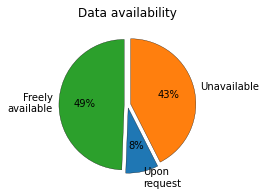

In [64]:
fig, axes = plt.subplots(figsize=(3, 3))
axes.pie([len(df_av), len(df_req), len(df_un)], labels=['Freely\navailable','Upon\nrequest','Unavailable'], 
         colors=['C2','C0','C1'], autopct='%1.0f%%', startangle=90,
         explode=[0.05, 0.05, 0.05],
         wedgeprops = {'linewidth': 0.3, 'edgecolor': 'black'})
axes.set_title('Data availability');